*facet* is composed of the following key components:

- **Model Inspection**

    _facet_ introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about *facet*'s model inspection capabilities, see the getting started example below.


- **Model Simulation**

    *facet*'s model simulation algorithms use ML models for _virtual experiments_ to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, *facet* utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of *facet*’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    *facet* offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. *facet* also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os

    if "cwd" not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(
                0, os.path.abspath(f"{cwd}/facet/{os.pardir}/{module_path}/src")
            )
        print(f"added `{sys.path[0]}` to python paths")


_set_paths()

del _set_paths

import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

working dir is '/Users/grisard_malo/PycharmProjects/githubFacet'
added `/Users/grisard_malo/PycharmProjects/githubFacet/pytools/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/facet/src` to python paths
added `/Users/grisard_malo/PycharmProjects/githubFacet/sklearndf/src` to python paths


# Pipelining & Model Ranking

In [2]:
# standard imports
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# relevant facet imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid

# load Boston housing dataset
boston = load_boston()
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names).assign(
    MEDIAN_HOUSE_PRICE=boston.target
)

# create facet sample object
boston_sample = Sample(observations=boston_df, target_name="MEDIAN_HOUSE_PRICE")

# create pipeline for random forest regressor
rforest_reg = RegressorPipelineDF(regressor=RandomForestRegressorDF(random_state=42))

# define grid of models which are "competing" against each other
rnd_forest_grid = [
    LearnerGrid(
        pipeline=rforest_reg, learner_parameters={"min_samples_leaf": [8, 11, 15]}
    )
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your models by performance (default is variance explained)
ranker = LearnerRanker(grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-3).fit(sample=boston_sample)

# get summary report
ranker.summary_report()

no match found for docstring '[see superclass' in class LearnerRanker


ranking_score  r2_score                                    regressor  \
                        mean       std       sem                     type   
rank                                                                        
0         0.721234  0.813158  0.045962  0.006500  RandomForestRegressorDF   
1         0.706528  0.801775  0.047623  0.006735  RandomForestRegressorDF   
2         0.691872  0.788968  0.048548  0.006866  RandomForestRegressorDF   

                       
     min_samples_leaf  
rank                   
0                   8  
1                  11  
2                  15

# Model inspection

*facet* implements several model inspection methods for
[scikit-learn](<https://scikit-learn.org/stable/index.html>) estimators.
Fundamentally, *facet* enables post-hoc model inspection by breaking down the interaction
effects of the variables that your model used for training:

- **Redundancy**
  represents how much information is shared between two features
  contributions to the model predictions. For example, temperature and pressure in a pressure cooker are
  redundant features for predicting cooking time since pressure will rise relative to
  the temperature, and vice versa. Therefore, knowing just one of either temperature or
  pressure will likely enable the same predictive accuracy. Redundancy is expressed as
  a percentage ranging from 0% (full uniqueness) to 100% (full redundancy).

- **Synergy**
  represents how much the combined information of two features contributes to
  the model predictions. For example, given features X and Y as
  coordinates on a chess board, the colour of a square can only be predicted when
  considering X and Y in combination. Synergy is expressed as a
  percentage ranging from 0% (full autonomy) to 100% (full synergy)

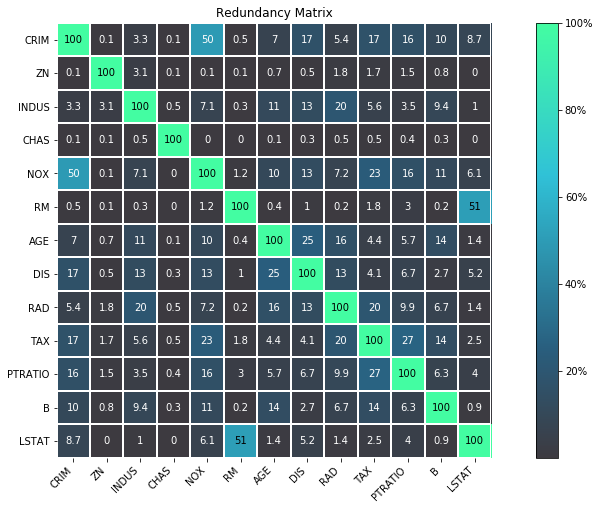

In [3]:
# fit the model inspector
from facet.inspection import LearnerInspector
inspector = LearnerInspector()
inspector.fit(crossfit=ranker.best_model_crossfit_)

# visualise redundancy as a matrix
from pytools.viz.matrix import MatrixDrawer
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

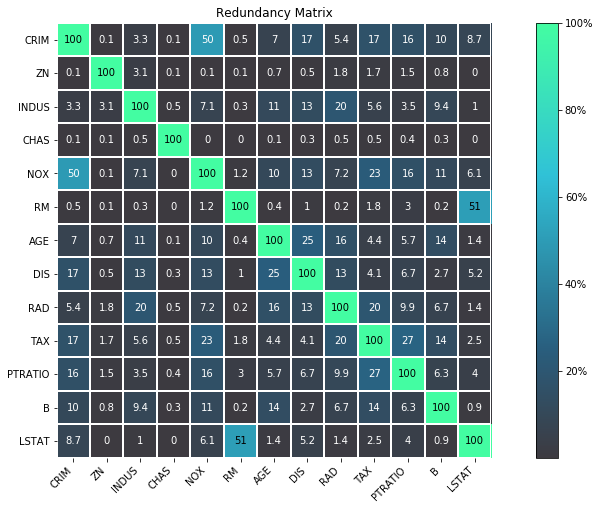

In [4]:
# save copy of plot to _static directories for documentation
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")
plt.savefig("facet/_static/redundancy_matrix.png", bbox_inches="tight", pad_inches=0)
plt.savefig(
    "facet/sphinx/source/_static/redundancy_matrix.png",
    bbox_inches="tight",
    pad_inches=0,
)

We can also better visualize redundancy as a dendrogram so we can identify clusters of features with redundancy.

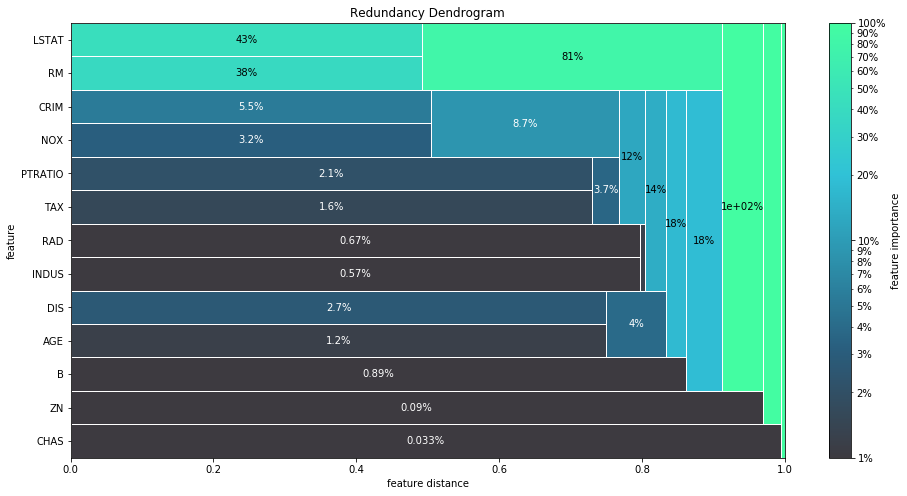

In [5]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

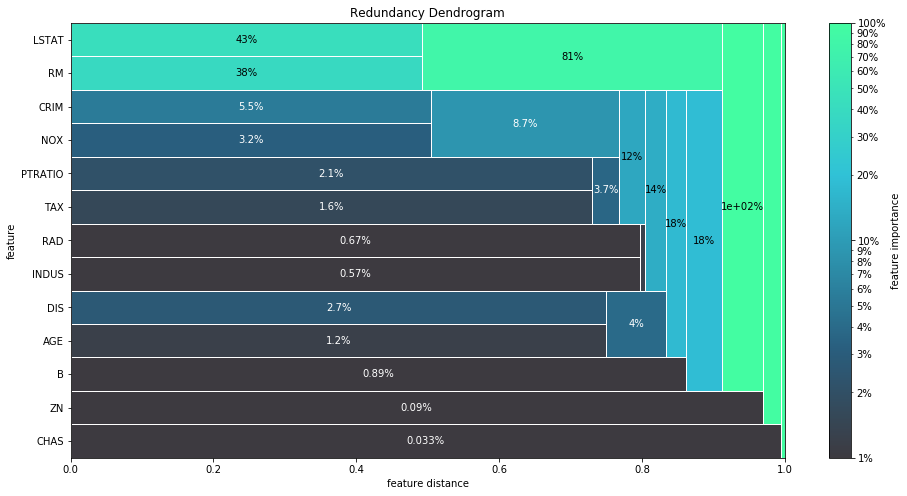

In [6]:
# save copy of plot to _static directories for documentation
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")
plt.savefig(
    "facet/_static/redundancy_dendrogram.png", bbox_inches="tight", pad_inches=0
)
plt.savefig(
    "facet/sphinx/source/_static/redundancy_dendrogram.png",
    bbox_inches="tight",
    pad_inches=0,
)

For feature synergy, we can get a similar picture

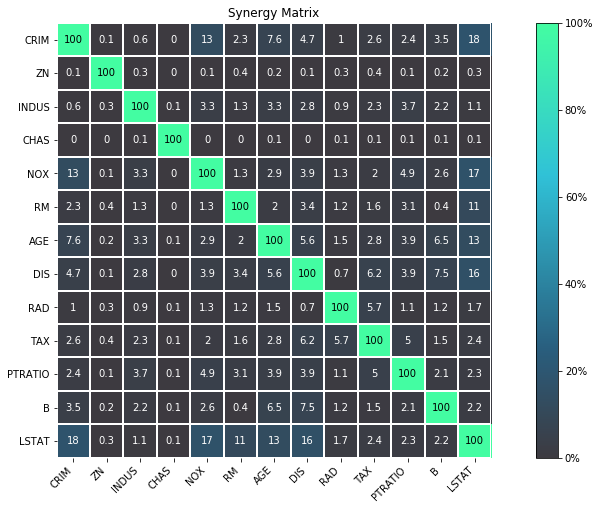

In [7]:
# visualise synergy as a matrix
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

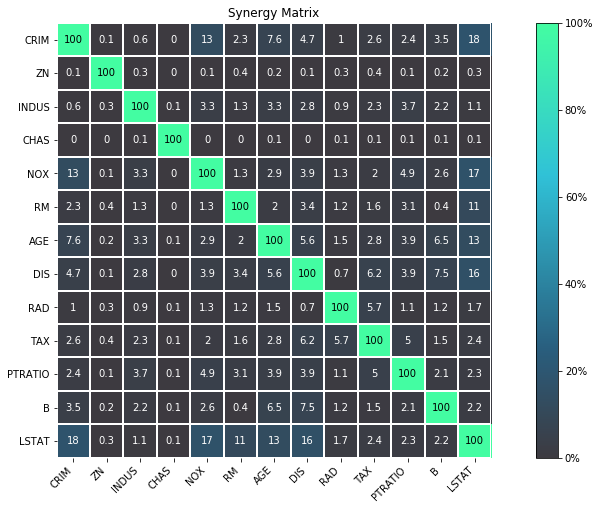

In [8]:
# save copy of plot to _static directories for documentation
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")
plt.savefig("facet/_static/synergy_matrix.png", bbox_inches="tight", pad_inches=0)
plt.savefig(
    "facet/sphinx/source/_static/synergy_matrix.png", bbox_inches="tight", pad_inches=0
)

Please see the API documentation for more detail.

# Simulation

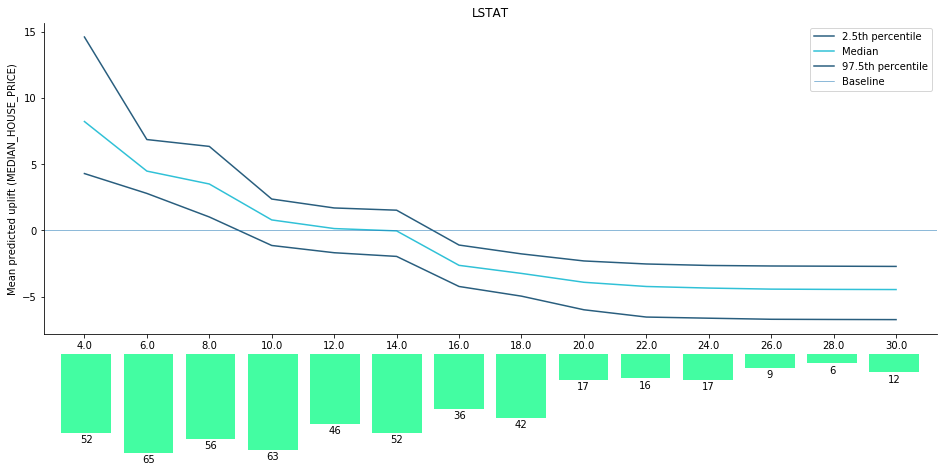

In [9]:
# facet imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=boston_sample)

SIM_FEAT = "LSTAT"
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(feature_name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)

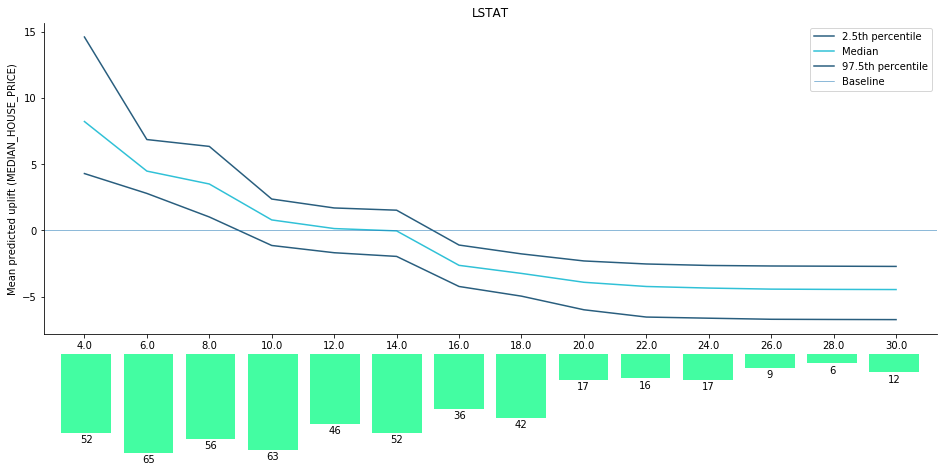

In [10]:
# save copy of plot to _static directories for documentation
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)
plt.savefig("facet/_static/simulation_output.png", bbox_inches="tight", pad_inches=0)
plt.savefig(
    "facet/sphinx/source/_static/simulation_output.png",
    bbox_inches="tight",
    pad_inches=0,
)